# Displaying cartographic data

In [1]:
from pathlib import Path
from skimage.io import imread
from scipy.interpolate import LinearNDInterpolator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Read the images and create dictionary for plotting in a loop.

After inspection we see that the one from 2004 is RGB (`img2004.shape` outputs `(600, 900, 3)`) and needs conversion to gray-scale.

This can be easily done by providing keyword argument `as_gray=True`.

In [2]:
data = Path("media/024-Cartography-Data-Analysis")

img1953 = imread(data / "O1953_9960_A3_1m.tif")
img1999 = imread(data / "O1999_9523_A3_1m.tif")
img2004 = imread(data / "O2004_2385c_A3_1m.tif", as_gray=True)

images = {1953: img1953, 1999: img1999, 2004: img2004}

Read data files with `pandas.read_csv` and name colums as `x` and `y` for ease of manipulation.

**Note:** skip first row by providing keyword `skiprows=1`.

In [3]:
study_area = pd.read_csv(data / "diff_analyse_grd.bln", names=["x", "y"], skiprows=1)
break_off_edge = pd.read_csv(data / "Abbruchkante.bln", names=["x", "y"], skiprows=1)
crack_edge = pd.read_csv(data / "Anrisskante.bln", names=["x", "y"], skiprows=1)

Read and inspect data (first rows, with `.head()` method) from countour file.

**Note:** need to manually remove first white space in the next file to make it work!

In [4]:
grid_data = pd.read_csv(data / "kr_99_A3_o25.dat", sep=" ", index_col=0)
grid_data.head()

,X[m],Y[m],Z[m],PCode,ErrCode,P_X[m],dh[m],DOF,D_XX[cm^2],D_YY[cm^2],D_ZZ[cm^2],D_XY[cm^2],D_XZ[cm^2],D_YZ[cm^2]
Punkt_ID,,,,,,,,,,,,,,
20,-1086.083,2086.729,1951.291,0,0,0.278,0.585,1,242.0,265.3,3676.4,-9.3,-125.6,302.5
21,-1061.750,2087.061,1958.021,0,0,0.381,0.121,1,246.6,265.3,3657.8,-9.3,-144.3,297.8
22,-1057.292,2087.043,1959.509,0,0,0.333,0.097,1,246.6,265.3,3653.1,-9.3,-144.3,297.8
23,-1053.635,2086.955,1960.838,0,0,0.348,0.092,1,246.6,265.3,3648.5,-14.0,-148.9,297.8
24,-1059.914,2086.027,1958.582,0,0,0.349,0.057,1,246.6,265.3,3657.8,-9.3,-144.3,302.5


Define image extent/axis limits as they will be used several times.

In [5]:
xmin, xmax = -1100, -200
ymin, ymax = 1500, 2100

Create the grid points for contours computation.

Use `LinearNDInterpolator` to create a function to produce the interpolation.

In [6]:
x = grid_data["X[m]"].to_numpy()
y = grid_data["Y[m]"].to_numpy()
z = grid_data["Z[m]"].to_numpy()

X = np.linspace(xmin, xmax, 900)
Y = np.linspace(ymin, ymax, 600)
X, Y = np.meshgrid(X, Y)

interp = LinearNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)

Inspect the range of `z` for giving a good bounds to levels.

In [7]:
z.min(), z.max()

(1515.177, 1997.486)

Put it all together and display the contours and lines over pictures.

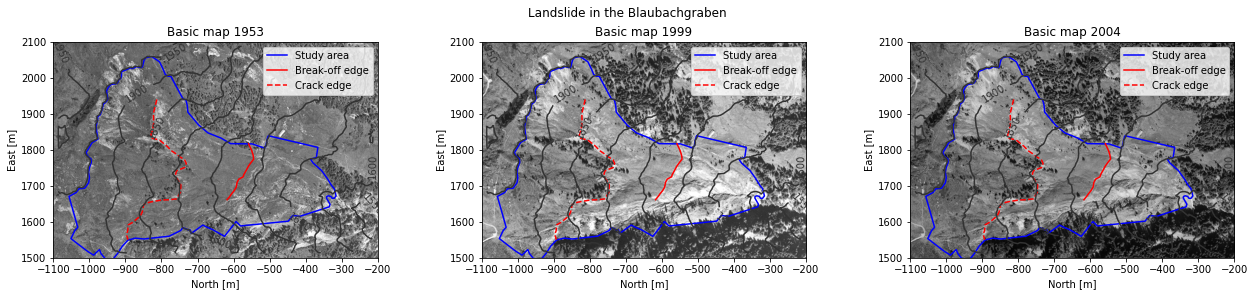

In [8]:
# Compute axis ticks.
xticks = np.arange(xmin, xmax + 1, 100)
yticks = np.arange(ymin, ymax + 1, 100)

levels = np.arange(1500, 2001, 50)

# Clean all and create new 1x3 figure.
plt.close("all")
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
fig.suptitle("Landslide in the Blaubachgraben")

for k, (year, image) in enumerate(images.items()):
    # Equilize histogram for similar display.
    # image = equalize_adapthist(image, clip_limit=0.01)
    
    # Display image title.
    ax[k].set_title(f"Basic map {year}")
    
    # -- MAIN IMAGE
    image = np.flipud(image)
    ax[k].imshow(image, cmap="gray", origin="lower",
                 extent=(xmin, xmax, ymin, ymax))
    
    # -- STUDY AREA
    x = study_area.x
    y = study_area.y
    ax[k].plot(x, y, "b-", label="Study area")
    
    # -- BREAK-OFF EDGE
    x = break_off_edge.x
    y = break_off_edge.y
    ax[k].plot(x, y, "r-", label="Break-off edge")
    
    # -- CRACK EDGE
    x = crack_edge.x
    y = crack_edge.y
    ax[k].plot(x, y, "r--", label="Crack edge")
    
    # -- ADD CONTOURS
    cs = ax[k].contour(X, Y, Z, levels=levels, colors="#333")
    ax[k].clabel(cs, inline=True, fontsize=10)
    
    # Define axis labels.
    ax[k].set_xlabel("North [m]")
    ax[k].set_ylabel("East [m]")
    
    # Define axis limits.
    ax[k].set_xlim(xmin, xmax)
    ax[k].set_ylim(ymin, ymax)
    
    # Define axis ticks.
    ax[k].set_xticks(xticks)
    ax[k].set_yticks(yticks)
    
    # Display legend on given position.
    ax[k].legend(loc="upper right", fancybox=True)
    
fig.tight_layout()